# Extracting Rules with XAI from RAPP predictions

## First three modules' performances to predict fourth semester success

In [1]:
import pandas as pd
import numpy as np

In [2]:
csv = "data/cs_first_three_modules_forth_term_cp.csv"
df = pd.read_csv(csv)

In [3]:
df.head()

,Geburtsjahr,Geschlecht,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,AlgoBestanden,AlgoVersuche,FourthTermCP
0,1972,männlich,1,1,1,1,1,2,120.0
1,1987,weiblich,1,1,1,1,1,1,180.0
2,1987,weiblich,1,1,0,0,0,0,40.0
3,1985,männlich,1,2,1,1,0,1,70.0
4,1987,männlich,0,0,1,2,1,2,10.0


Let us change the task to a binary classification problem. Assuming 30 ECTP per term, we end up with 120 CP after the fourth semester. Giving some leeway, we allow for 20 CP to be missing (two modules).

In [4]:
df_classification = df.copy(deep=True)
df_classification["FourthTermCP"] = 1*(df_classification["FourthTermCP"] >= 100)

In [5]:
df_classification.head()

,Geburtsjahr,Geschlecht,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,AlgoBestanden,AlgoVersuche,FourthTermCP
0,1972,männlich,1,1,1,1,1,2,1
1,1987,weiblich,1,1,1,1,1,1,1
2,1987,weiblich,1,1,0,0,0,0,0
3,1985,männlich,1,2,1,1,0,1,0
4,1987,männlich,0,0,1,2,1,2,0


We need to one-hot encode the gender.

In [6]:
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)

In [7]:
df_classification.head()

,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,AlgoBestanden,AlgoVersuche,FourthTermCP,Männlich,Weiblich,Divers
0,1,1,1,1,1,2,1,1,0,0
1,1,1,1,1,1,1,1,0,1,0
2,1,1,0,0,0,0,0,0,1,0
3,1,2,1,1,0,1,0,1,0,0
4,0,0,1,2,1,2,0,1,0,0


### Prepare train and test set

In [33]:
X = df_classification.drop(["FourthTermCP"], axis=1)
y = df_classification["FourthTermCP"]

feature_names = X.columns

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### Train classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [26]:
clf = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)

In [27]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [28]:
y_pred = clf.predict(X_train)
bacc = balanced_accuracy_score(y_train, y_pred)
conf = confusion_matrix(y_train, y_pred)
print("# Trainset")
print(f"Balanced accuracy: {bacc}")
print(f"Confusion Matrix (tn, fp, fn, tp):")
print(conf)

y_pred = clf.predict(X_test)
bacc = balanced_accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
print("# Testset")
print(f"Balanced accuracy: {bacc}")
print(f"Confusion Matrix (tn, fp, fn, tp):")
print(conf)

# Trainset
Balanced accuracy: 0.8303076560227467
Confusion Matrix (tn, fp, fn, tp):
[[1074  297]
 [  41  293]]
# Testset
Balanced accuracy: 0.8248614072494669
Confusion Matrix (tn, fp, fn, tp):
[[361 108]
 [ 12  88]]


### Display rules learned

In [29]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]

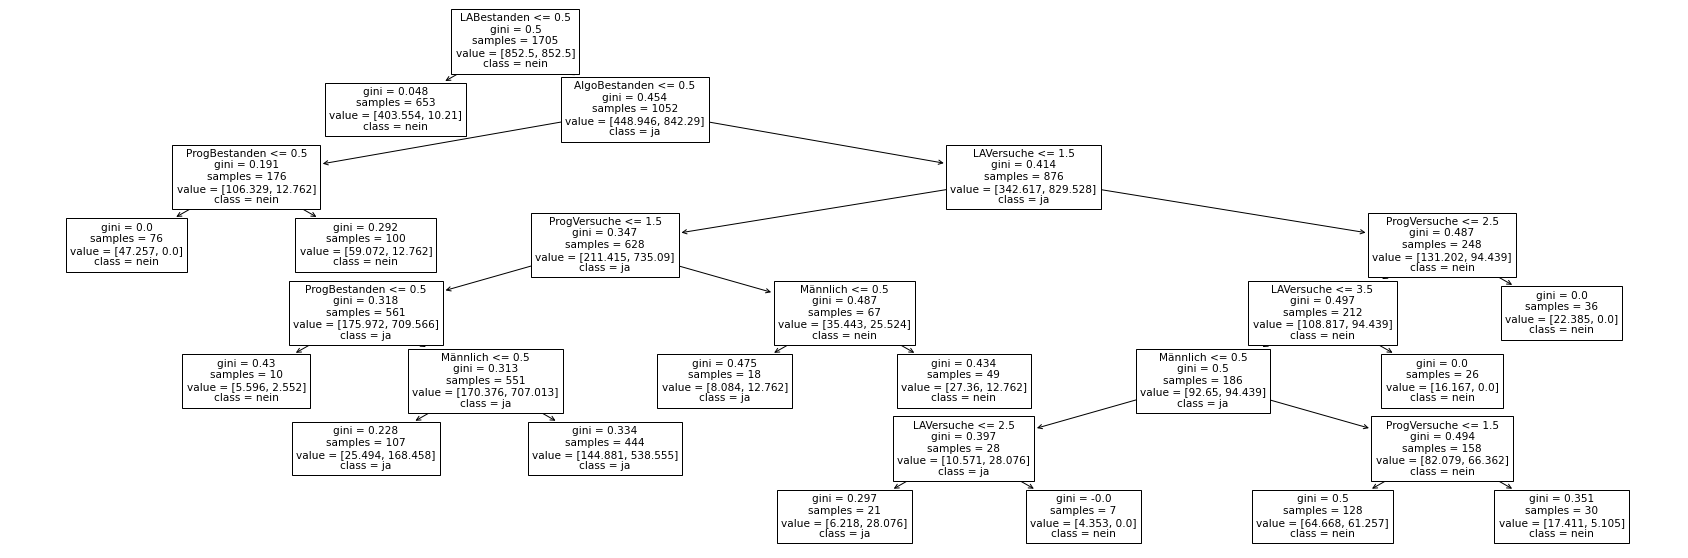

In [34]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

Most discriminatory feature is LA1. Students who do not pass it will not have enough credits at end of fourth term.
Makes sense as students who do not pass it might not reach end of third term anyway.

## Only checking for LA attempts, not if LA was passed

In [37]:
X = df_classification.drop(["FourthTermCP", "LABestanden"], axis=1)
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
clf = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
bacc = balanced_accuracy_score(y_train, y_pred)
conf = confusion_matrix(y_train, y_pred)
print("# Trainset")
print(f"Balanced accuracy: {bacc}")
print(f"Confusion Matrix (tn, fp, fn, tp):")
print(conf)

y_pred = clf.predict(X_test)
bacc = balanced_accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
print("# Testset")
print(f"Balanced accuracy: {bacc}")
print(f"Confusion Matrix (tn, fp, fn, tp):")
print(conf)

# Trainset
Balanced accuracy: 0.8230137099979472
Confusion Matrix (tn, fp, fn, tp):
[[1054  317]
 [  41  293]]
# Testset
Balanced accuracy: 0.813134328358209
Confusion Matrix (tn, fp, fn, tp):
[[350 119]
 [ 12  88]]


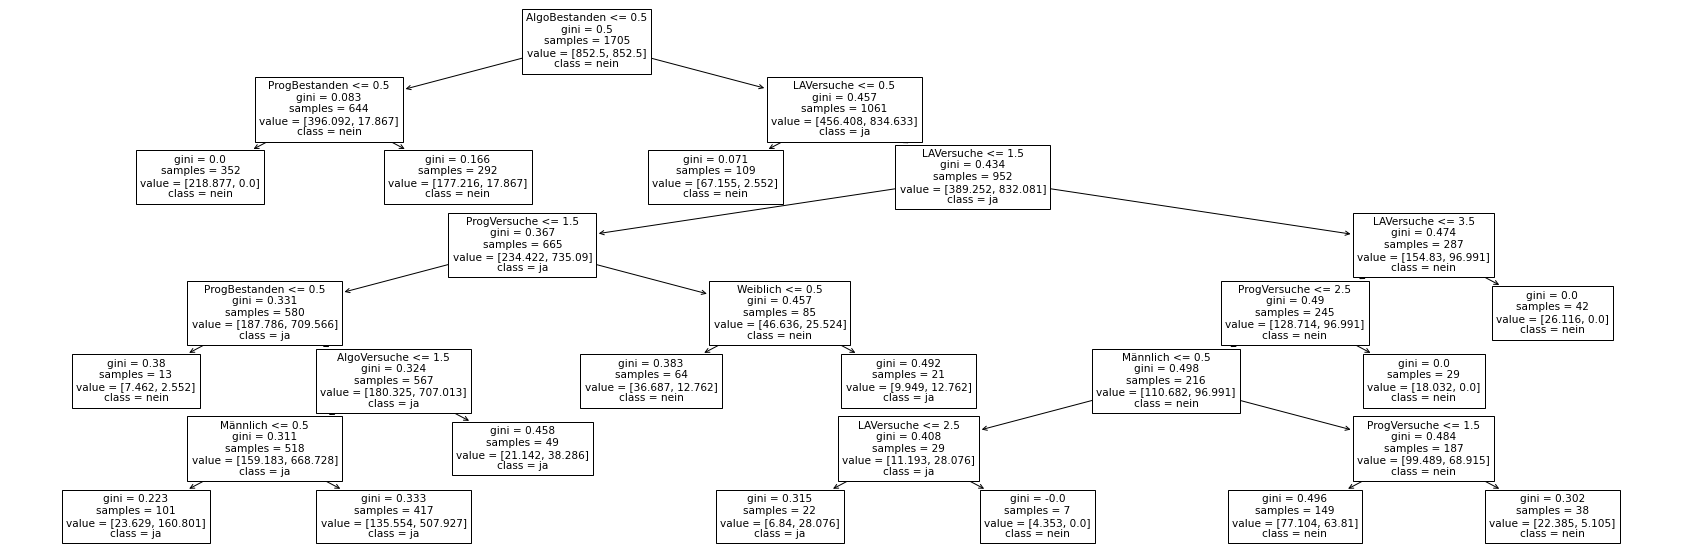

In [38]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()